In [3]:
import numpy as np
import matplotlib.pyplot as plt
import control

# 「- Hybrid Pendulum -」

In [17]:
def dyn_hbpd(state, g, l, lam, u):
    theta, omega = state
    dtheta = omega
    domega = -g/l * np.sin(theta) - lam * omega + u
    return np.array([dtheta, domega])

def sim_hbpd(theta0, omega0,
             g, l, lam,
             theta_star, 
             domega,
             T, dt,
             ts = None,
             lqr_flag=False, K=None,
             t_ref=None, theta_ref=None, omega_ref=None,
             w_flag=False,
             t_w=None,
             w=None):
    
    t_values = []
    theta_values = []
    omega_values = []
    u_values = []

    state = np.array([theta0, omega0])

    N = int(T / dt)
    for i in range(N+1):
        current_t = i * dt

        if (w_flag) and (current_t >= t_w):
            state[1] += w
            w_flag = False

        t_values.append(current_t)
        theta_values.append(state[0])
        omega_values.append(state[1])

        if lqr_flag:
            if len(theta_values) < ts: # --- Collect Hankel history state

                # Create padding arrays filled with the initial condition values
                pad_rows = ts - len(theta_values)
                pad_theta = np.full(pad_rows, theta_values[0])
                pad_omega = np.full(pad_rows, omega_values[0])
                
                # Concatenate the padding with the available data
                padded_theta = np.concatenate((pad_theta, theta_values))
                padded_omega = np.concatenate((pad_omega, omega_values))
                padded_X = np.column_stack((padded_theta, padded_omega))
            else:
                padded_X = np.column_stack((theta_values[-ts:], omega_values[-ts:]))   
            X_history = padded_X[1:, :].reshape(-1)
            X_current = np.array([state[0], state[1]])
            X = np.concatenate([X_history, X_current])

            if len(theta_values) < ts: # --- Collect Hankel reference
                
                # Create padding arrays filled with the initial condition values
                pad_rows = ts - len(theta_values)
                pad_theta_ref = np.full(pad_rows, theta_ref[0])
                pad_omega_ref = np.full(pad_rows, omega_ref[0])
                
                # Concatenate the padding with the available data
                padded_theta_ref = np.concatenate((pad_theta_ref, theta_ref[:len(theta_values)]))
                padded_omega_ref = np.concatenate((pad_omega_ref, omega_ref[:len(theta_values)]))
                padded_Xref = np.column_stack((padded_theta_ref, padded_omega_ref))
            else:
                padded_Xref = np.column_stack((theta_ref[(i+1)-ts:(i+1)], omega_ref[(i+1)-ts:(i+1)]))
            Xref_history = padded_Xref[1:, :].reshape(-1) 
            Xref_current = np.array([theta_ref[i], omega_ref[i]])
            Xref = np.concatenate([Xref_history, Xref_current])

            Error = (Xref - X).reshape(-1,1)
            if not abs(state[0]-theta_star)<2*1e-1 and not abs(state[0]+theta_star)<2*1e-1:
                u_lqr = K @ Error
                u_lqr = u_lqr.reshape(-1)
                u_lqr = u_lqr[-1]
                u_hat = u_lqr
            else:
                u_hat = 0
        else:
            u_hat = 0
        u_bar = lam * state[1]
        u = u_bar + u_hat
        u_values.append(u)

        state_derivs = dyn_hbpd(state, g, l, lam, u)
        state_next = state + dt * state_derivs

        if state_next[0] >= theta_star:
            state_next = np.array([theta_star, state_next[1] - domega])
        elif state_next[0] <= -theta_star:
            state_next = np.array([-theta_star, state_next[1] + domega])
        state = state_next

    return {
        't': np.array(t_values),
        'theta': np.array(theta_values),
        'omega': np.array(omega_values),
        'u': np.array(u_values)
    }

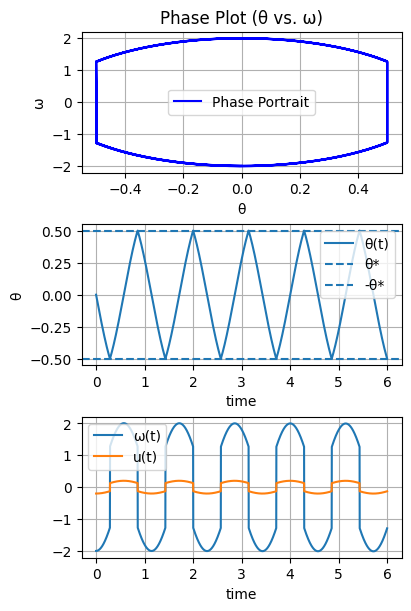

In [6]:
g = 9.81
l = 1.0
lam = 0.1
theta_star = 0.5
domega = 1.2691337046208242 * 2  
theta0 = 0.0
omega0 = -2.0
t_disturbance = 0.35  
w = 0.6               
T = 6
dt = 1e-3

res = sim_hbpd(theta0, omega0,
               g, l, lam,
               theta_star,
               domega,
               T, dt,
               ts=None,
               lqr_flag=False, K=None,
               t_ref=None, theta_ref=None, omega_ref=None,
               w_flag=False,
               t_w=None,
               w=None)

time = res['t']
theta = res['theta']
omega = res['omega']
u = res['u']


fig, axs = plt.subplots(3, 1, figsize=(4, 6), constrained_layout=True)
# Phase portrait
axs[0].plot(theta, omega, 'b-', lw=1.5, label='Phase Portrait')
axs[0].set_title('Phase Plot (θ vs. ω)')
axs[0].set_xlabel('θ')
axs[0].set_ylabel('ω')
axs[0].grid(True)
axs[0].legend()
# θ(t) vs. time
axs[1].plot(time, theta, lw=1.5, label='θ(t)')
axs[1].axhline(theta_star, linestyle='--', label='θ*')
axs[1].axhline(-theta_star, linestyle='--', label='-θ*')
axs[1].set_xlabel('time')
axs[1].set_ylabel('θ')
axs[1].grid(True)
axs[1].legend()
# ω(t)/u(t) vs. time
axs[2].plot(time, omega, lw=1.5, label='ω(t)')
axs[2].plot(time, u, lw=1.5, label='u(t)')
axs[2].set_xlabel('time')
axs[2].grid(True)
axs[2].legend()
plt.show()

time_ref = time
theta_ref = theta
omega_ref = omega
u_ref = u

# 「- Hankel Prediction -」

Pre-process data set dimension (601, 3)
Time snap shot (M): 601
Original state dimension (n): 3
Hankel delay (ts): 110
Hankel window (tw): 90
Hankel matrix dimension (330, 90)
L.shape (330, 330)


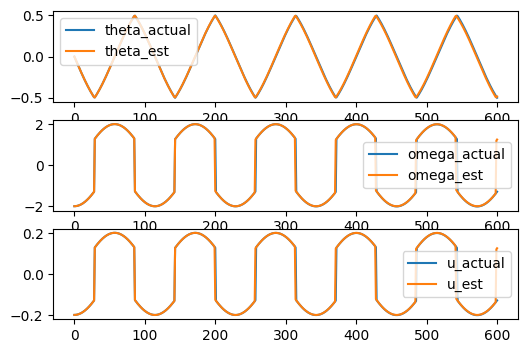

In [7]:
sample_rate = 10
time_sample = time[::sample_rate]
theta_sample = theta[::sample_rate]
omega_sample = omega[::sample_rate]
u_sample = u[::sample_rate]
data_set = np.column_stack((theta_sample, omega_sample, u_sample))
print('Pre-process data set dimension', data_set.shape)
print(f"Time snap shot (M): {data_set.shape[0]}")
print(f'Original state dimension (n): {data_set.shape[1]}')
print('=============')

H = []
n = 3    # original state space dimension
ts = 110  # the row size of H
tw = 90  # the col size of H, and make sure (ts + tw) < n_steps

for i in range(ts):  
    H.append(data_set[i:tw+i,:].T)       # Extract and transpose
H = np.vstack(H)                         # Stack all elements vertically
print('Hankel delay (ts):', ts )         # = original_state_dim * delay_state
print('Hankel window (tw):', tw)
print('Hankel matrix dimension', H.shape)
print('=============')

edmd_snap_X = H[:, :-1]
edmd_snap_Y = H[:, 1:]
L = np.dot(edmd_snap_Y, np.linalg.pinv(edmd_snap_X))
print('L.shape', L.shape)

x0 = H[:,0]
x_edmd = np.zeros((data_set.shape[0], x0.size))
x_edmd[0] = x0.copy()
for i in range(data_set.shape[0]-1):
    x_edmd[i + 1] =(L @ x_edmd[i])
figure = plt.figure(figsize=(6,4))
plt.subplot(3,1,1)
plt.plot(data_set[:,0], label='theta_actual')
plt.plot(x_edmd[:,0], label='theta_est')
plt.legend()
plt.subplot(3,1,2)
plt.plot(data_set[:,1], label='omega_actual')
plt.plot(x_edmd[:,1], label='omega_est')
plt.legend()
plt.subplot(3,1,3)
plt.plot(data_set[:,2], label='u_actual')
plt.plot(x_edmd[:,2], label='u_est')
plt.legend()
plt.show()

# 「- LQR Gain K Design -」

In [8]:
def euler_discrete_to_continuous(A, B, dt):
    A_c = (A - np.eye(A.shape[0])) / dt
    B_c = B / dt
    return A_c, B_c

L_bar_top_blocks = []
L_bar_bottom_blocks = []

for i in range(ts):
    start = i * 3
    L_bar_top_blocks.append(L[start:start+2, :])  # (2, n)
    L_bar_bottom_blocks.append(L[start+2:start+3, :])  # (1, n)

L_bar_top = np.vstack(L_bar_top_blocks)  
L_bar_bottom = np.vstack(L_bar_bottom_blocks)  
print('L_x.shape', L_bar_top.shape)
print('L_u.shape', L_bar_bottom.shape)

A = L_bar_top[:, :2*ts]
B = L_bar_top[:, 2*ts:]
print('A.shape', A.shape)
print('B.shape', B.shape)

A_c, B_c = euler_discrete_to_continuous(A, B, sample_rate * dt)
print('A_c.shape', A_c.shape)
print('B_c.shape', B_c.shape)

L_x.shape (220, 330)
L_u.shape (110, 330)
A.shape (220, 220)
B.shape (220, 110)
A_c.shape (220, 220)
B_c.shape (220, 110)


In [9]:
q_theta = 1e-5
q_omega = 1e-5
q = [val for _ in range(ts) for val in [q_theta, q_omega]]
q[-2] = 1e8
q[-1] = 1e6
Q = np.diag(q)
r = [1e3] * ts
r[-1] = 1e1
R = np.diag(r)
print('Q.shape', Q.shape)
print('R.shape', R.shape)

K, S, E = control.lqr(A_c, B_c, Q, R)
print('K.shape', K.shape)

print('====================')
K_current = K[-1,:]
print_index = 600
print_K = K_current[-print_index*n:]
for j, val in enumerate(print_K, start=1):
    scalar_val = val.item()  # or use: scalar_val = float(val)
    print(f'Gain: {scalar_val:.2f}')
    if j % 2 == 0:
        print('---')

Q.shape (220, 220)
R.shape (110, 110)
K.shape (110, 220)
Gain: -0.01
Gain: -0.06
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.06
Gain: -0.01
---
Gain: -0.01
Gain: -0.07
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.07
Gain: -0.01
---
Gain: -0.01
Gain: -0.07
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.07
Gain: -0.01
---
Gain: -0.01
Gain: -0.07
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.08
Gain: -0.01
---
Gain: -0.01
Gain: -0.08
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.08
Gain: -0.01
---
Gain: -0.01
Gain: -0.08
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.08
Gain: -0.01
---
Gain: -0.01
Gain: -0.08
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.09
Gain: -0.01
---
Gain: -0.01
Gain: -0.09
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.08
Gain: -0.01
---
Gain: -0.01
Gain: -0.08
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.08
Gain: -0.01
---
Gain: -0.01
Gain: -0.09
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.09
Gain: -0.01
---
Gain: -0.01
Gain: -0.09
---
Gain: -0.01
Gain: -0.01
---
Gain: -0.08
Gain: -0.01
---
Gain: -0.01
Gain: -

# 「- Control Result -」

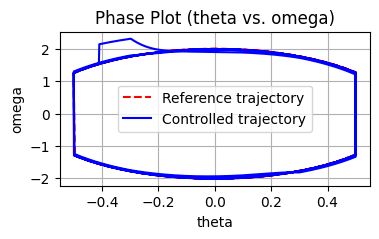

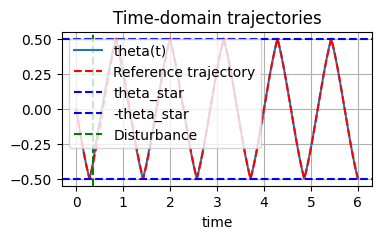

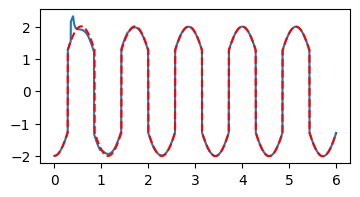

In [18]:
res = sim_hbpd(theta0, omega0,
               g, l, lam,
               theta_star,
               domega,
               T, dt,
               ts=ts,
               lqr_flag=True, K=K,
               t_ref=time_ref, theta_ref=theta_ref, omega_ref=omega_ref,
               w_flag=True,
               t_w=0.35,
               w=0.6)
t = res['t']
theta = res['theta']
omega = res['omega']

plt.figure(figsize=(4, 2))
plt.plot(theta_ref, omega_ref, 'r--', lw=1.5, label='Reference trajectory')
plt.plot(theta, omega, 'b-', lw=1.5, label='Controlled trajectory')
plt.title('Phase Plot (theta vs. omega)')
plt.xlabel('theta')
plt.ylabel('omega')
plt.grid(True)
plt.legend()
plt.show()
plt.figure(figsize=(4, 2))
plt.plot(t, theta, label='theta(t)', lw=1.5)
plt.plot(time_ref[:len(t)], theta_ref[:len(t)], 'r--', lw=1.5, label='Reference trajectory')
plt.axhline(theta_star, color='b', linestyle='--', label='theta_star')
plt.axhline(-theta_star, color='b', linestyle='--', label='-theta_star')
plt.axvline(t_disturbance, color='g', linestyle='--', label='Disturbance')
plt.title('Time-domain trajectories')
plt.xlabel('time')
plt.grid(True)
plt.legend()
plt.show()
plt.figure(figsize=(4, 2))
plt.plot(t, omega, label='omega(t)', lw=1.5)
plt.plot(time_ref[:len(t)], omega_ref[:len(t)], 'r--', lw=1.5, label='Reference trajectory')
plt.show()